In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, recall_score, roc_curve, auc, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("framingham.csv")
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


***We can see that in the dataset only 500+ people are having CHD and 3500+ people are don't have any attack of CHD, so it is a highly imbalanced dataset***

<ipython-input-6-6c1718deabc8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TenYearCHD', data=df, palette='BuGn_r')


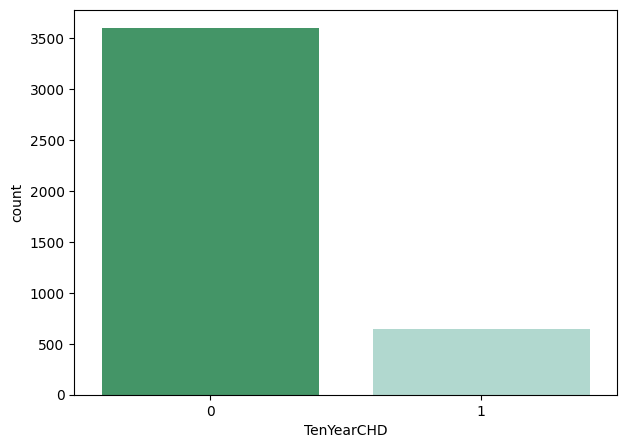

In [6]:
plt.figure(figsize=(7, 5))
sns.countplot(x='TenYearCHD', data=df, palette='BuGn_r')
plt.show()

***We also have missing values, by imputation method we can handle it***

In [7]:
df.isnull().sum()

,0
male,0
age,0
education,105
currentSmoker,0
cigsPerDay,29
BPMeds,53
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,50


Here we are separating the numerical features from our dataset, and create a pipeline called numeric_transformer which chain together the multiple data processing steps.
*1st it perform the statistical imputation (MEDIAN imputation) then scale down the feature values.*

In [8]:
numeric_features = ['age', 'education', 'cigsPerDay', 'totChol', 'sysBP',
                    'diaBP', 'BMI', 'heartRate', 'glucose']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

***Similarly we are going to do this on categorical feature also by MODE Imputation.***

In [10]:
categorical_features = ['male', 'currentSmoker', 'BPMeds', 'prevalentStroke',
                        'prevalentHyp', 'diabetes']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

ColumnTransformer allows us to apply different preprocessing steps to different columns in the dataset. It's useful when we have multiple numerical and categorical column and each requiring different transformation.
Argument Transformer takes a list of tuples, each tuple defines a transformation to be applied to a specific columns
**Tuple Structure: ('name', transformer, columns)**

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [12]:
X = df.drop('TenYearCHD', axis=1)
Y = df['TenYearCHD']

Now handling the imbalanced in the dataset using SMOTE (Synthetic Minority Over-sampling), it's balanced the dataset by creating synthetic samples of the minority class (In this case people with CHD)
preprocessor.fit_transform(X) part first applies the preprocessing steps defined earlier (like imputation and scaling) to the input features then apply SMOTE.

In [16]:
smote = SMOTE(random_state=42)
X_resample, Y_resample = smote.fit_resample(preprocessor.fit_transform(X), Y)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resample, Y_resample, test_size=0.3, random_state=42)


It creates the Pipeline of the model that will be fit on the dataset later.

In [18]:
model = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

This is a dictionary to store different possible values of the hyperparemeters which gives best model.
Will use this values to do hyperparameter tuning.

In [21]:
param_dist = {
    'classifier__n_estimators': [100, 500, 1000, 1500],
    'classifier__max_depth': [None, 5, 8, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None]
}

In [19]:
scoring = {
    'Accuracy': 'accuracy',
    'recall(TPR)': make_scorer(recall_score),
    'TNR': make_scorer(lambda y_true, y_pred: confusion_matrix(y_true, y_pred).ravel()[0] / (confusion_matrix(y_true, y_pred).ravel()[0] + confusion_matrix(y_true, y_pred).ravel()[1]))
}

RandomizedSearchCV will optimize the hyperparameters of the model created earlier and finally retain the model with the best hyperparameters it found.

In [26]:
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring=scoring,
    refit='recall(TPR)',
    random_state=42,
    n_jobs=-1
)

fit the training dataset on the model and using it find the best parameter for the model and train the final model using those optimal parameters

In [27]:
random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classifier__class_weight': ['balanced',
                                                                     'balanced_subsample',
                                                                     None],
                                        'classifier__max_depth': [None, 5, 8,
                                                                  10, 15],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 500,
                                                                     1000,
                                                                     1500]},
                   random_state=42, refit='recall(TPR)',
                   scoring={'Accuracy': 'accuracy',
                            'TNR': make_scorer(<lambda>, response_method='predict'),
                            'recall(TPR)': make_scorer(recall_score, response_method='predict')})

In [28]:
best_model = random_search.best_estimator_

In [29]:
Y_pred = best_model.predict(X_test)

In [30]:
print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'classifier__n_estimators': 1000, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__class_weight': 'balanced'}


In [32]:
print(f"Accuracy: {accuracy_score(Y_test, Y_pred):.2f}")

Accuracy: 0.91


In [33]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
print(f"TPR: {tpr:.2f}, TNR: {tnr:.2f}")

TPR: 0.90, TNR: 0.91


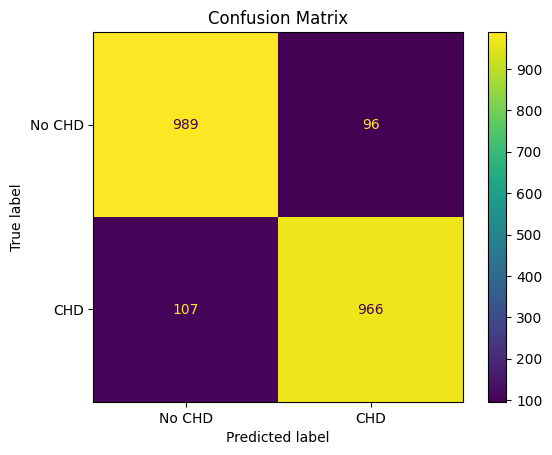

In [34]:
from matplotlib import pyplot as plt
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No CHD', 'CHD'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [35]:
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1085
           1       0.91      0.90      0.90      1073

    accuracy                           0.91      2158
   macro avg       0.91      0.91      0.91      2158
weighted avg       0.91      0.91      0.91      2158



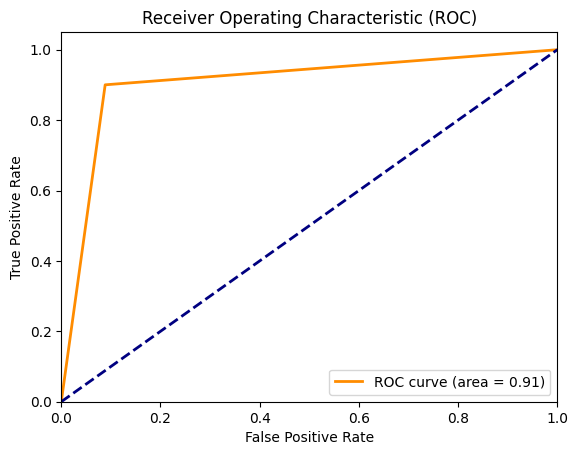

In [36]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

***So we can conclude that our best RandomForestModel found with:***
1. **1000 trees**
2. **classifier__min_samples_split: 2**, A node will
  be split if it has atleast 2 samples.
3. Leaf node should contain atmost 1 sample
4. No restriction on the depth of the each trees
5. **classifier__class_weight: 'balanced'**
   It means our model gives more importance to the minority class (people with CHD) during training and improves its prediction accuracy.